In [1]:


import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import random

In [2]:
from transformers import AutoModel, AutoTokenizer

model_name = "dkleczek/bert-base-polish-cased-v1"
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)




/home/julita/anaconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [4]:
from datasets import load_dataset

# Wczytanie zbioru danych
dataset = load_dataset("clarin-knext/wsd_polish_datasets", trust_remote_code=True)

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'tokens', 'phrases', 'wsd'],
        num_rows: 7848
    })
})

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Wybierz przykładowe zdania z korpusu
texts = [example["text"] for example in dataset["train"].select(range(300))]  # Przykładowo 100 zdań


# Oblicz reprezentacje dla każdego zdania
embeddings = []
for text in texts:
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)
    outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()
    embeddings.append(cls_embedding)

# Spłaszcz listę reprezentacji
embeddings = np.vstack(embeddings)

# Oblicz macierz podobieństw cosinusowych
cosine_similarities = cosine_similarity(embeddings)

# Wyciągnij tylko górny trójkąt macierzy podobieństw, aby uniknąć duplikatów
similarity_values = cosine_similarities[np.triu_indices_from(cosine_similarities, k=1)]

# Średnia i odchylenie standardowe podobieństwa cosinusowego
mean_similarity = np.mean(similarity_values)
std_similarity = np.std(similarity_values)

print(f"Średnie podobieństwo cosinusowe: {mean_similarity}")
print(f"Odchylenie standardowe: {std_similarity}")


Średnie podobieństwo cosinusowe: 0.4148353934288025
Odchylenie standardowe: 0.120530866086483


In [10]:
print(text)

Biznes ten daje pracę 2,3 mln osób.


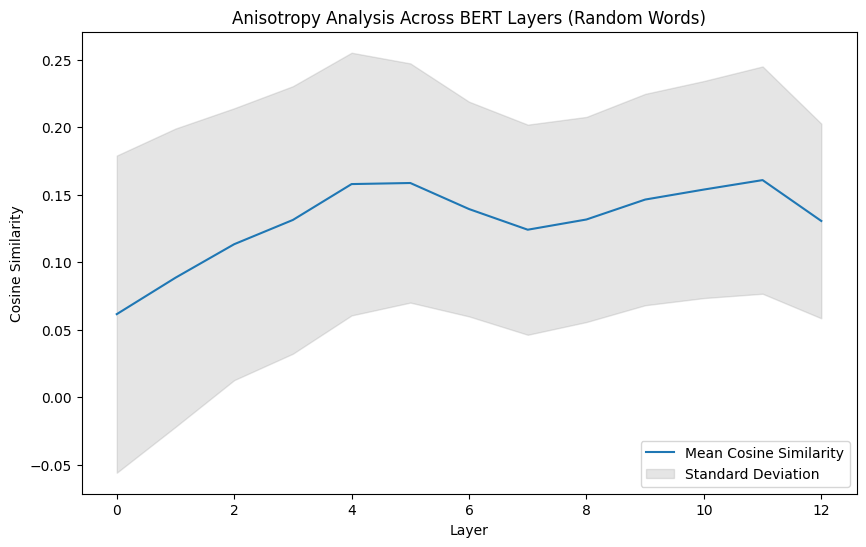

In [11]:
layer_similarities = {}

model.config.output_hidden_states = True

layer_similarities = {}

# Process each text
for text in texts:
    # Tokenize and get model outputs with hidden states for each layer
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)
    outputs = model(**inputs)

    # Select a random word from the tokenized input (not [CLS] or [SEP])
    input_ids = inputs["input_ids"][0].tolist()
    random_word_index = random.randint(1, len(input_ids) - 2)  # Exclude CLS and SEP tokens

    # Iterate over each layer and extract the embedding for the random word
    for layer_index, hidden_state in enumerate(outputs.hidden_states):
        word_embedding = hidden_state[0, random_word_index, :].detach().numpy()
        
        if layer_index not in layer_similarities:
            layer_similarities[layer_index] = []
        
        layer_similarities[layer_index].append(word_embedding)

# Calculate mean and std deviation of cosine similarity for each layer
mean_similarities = []
std_similarities = []

for layer_index, embeddings in layer_similarities.items():
    embeddings = np.vstack(embeddings)
    cosine_similarities = cosine_similarity(embeddings)
    similarity_values = cosine_similarities[np.triu_indices_from(cosine_similarities, k=1)]
    
    mean_similarity = np.mean(similarity_values)
    std_similarity = np.std(similarity_values)
    
    mean_similarities.append(mean_similarity)
    std_similarities.append(std_similarity)

# Plot the results
layers = list(range(len(mean_similarities)))

plt.figure(figsize=(10, 6))
plt.plot(layers, mean_similarities, label='Mean Cosine Similarity')
plt.fill_between(layers, 
                 np.array(mean_similarities) - np.array(std_similarities), 
                 np.array(mean_similarities) + np.array(std_similarities), 
                 color='gray', alpha=0.2, label='Standard Deviation')
plt.xlabel("Layer")
plt.ylabel("Cosine Similarity")
plt.title("Anisotropy Analysis Across BERT Layers (Random Words)")
plt.legend()
plt.show()

# (Context-Specificity)